# 1. Imports

In [136]:
import pandas as pd
from IPython.display import display
from IPython.display import Image
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec


import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.float_format', lambda x :'%5f' %x)

sns.set(rc={'figure.figsize': (40,25)})

# 2. Data loads

In [3]:
data = pd.read_csv('Data/predictionStoreP03.csv', parse_dates=['date','year_week','competition_since','promo_since'])
data.loc[data.competition_distance == data['competition_distance'].max(), 'competition_distance'] = 80000

# 3. Data filtering

In [4]:
df = data.loc[data['open'] != 0 & (data['sales'] > 0)]    
df = df.drop(['customers','open','promo_interval', 'month_map'], axis=1)

# 4. Exploratory data analysis

## 4.1 Creation of variables

In [384]:
df['promo_type'] = df[['year_week', 'sales','promo','promo2']].apply(
    lambda x: 'Nenhuma Promoção' if (x['promo'] == 0) &(x['promo2'] == 0) else 'Apenas Promoção 1' if (x['promo'] == 1) &(x['promo2'] == 0) else 'Apenas Promoção 2'
    if (x['promo'] == 0) &(x['promo2'] == 1) else "Ambas as promoções",
    axis=1
)
df['semester'] = df['month'].apply(lambda x: 1 if x <= 6 else 2)

## 4.2 Bivariate analysis 

### 4.2.1 Teste de Hipóteses

### 1. Lojas com maior sortimento deveriam vender mais.  

    True
    Lojas com maior sortimento realmente tem uma média de venda mais alta.
    Demonstrando inlcusive uma tendência de aumento com o passar dos anos.

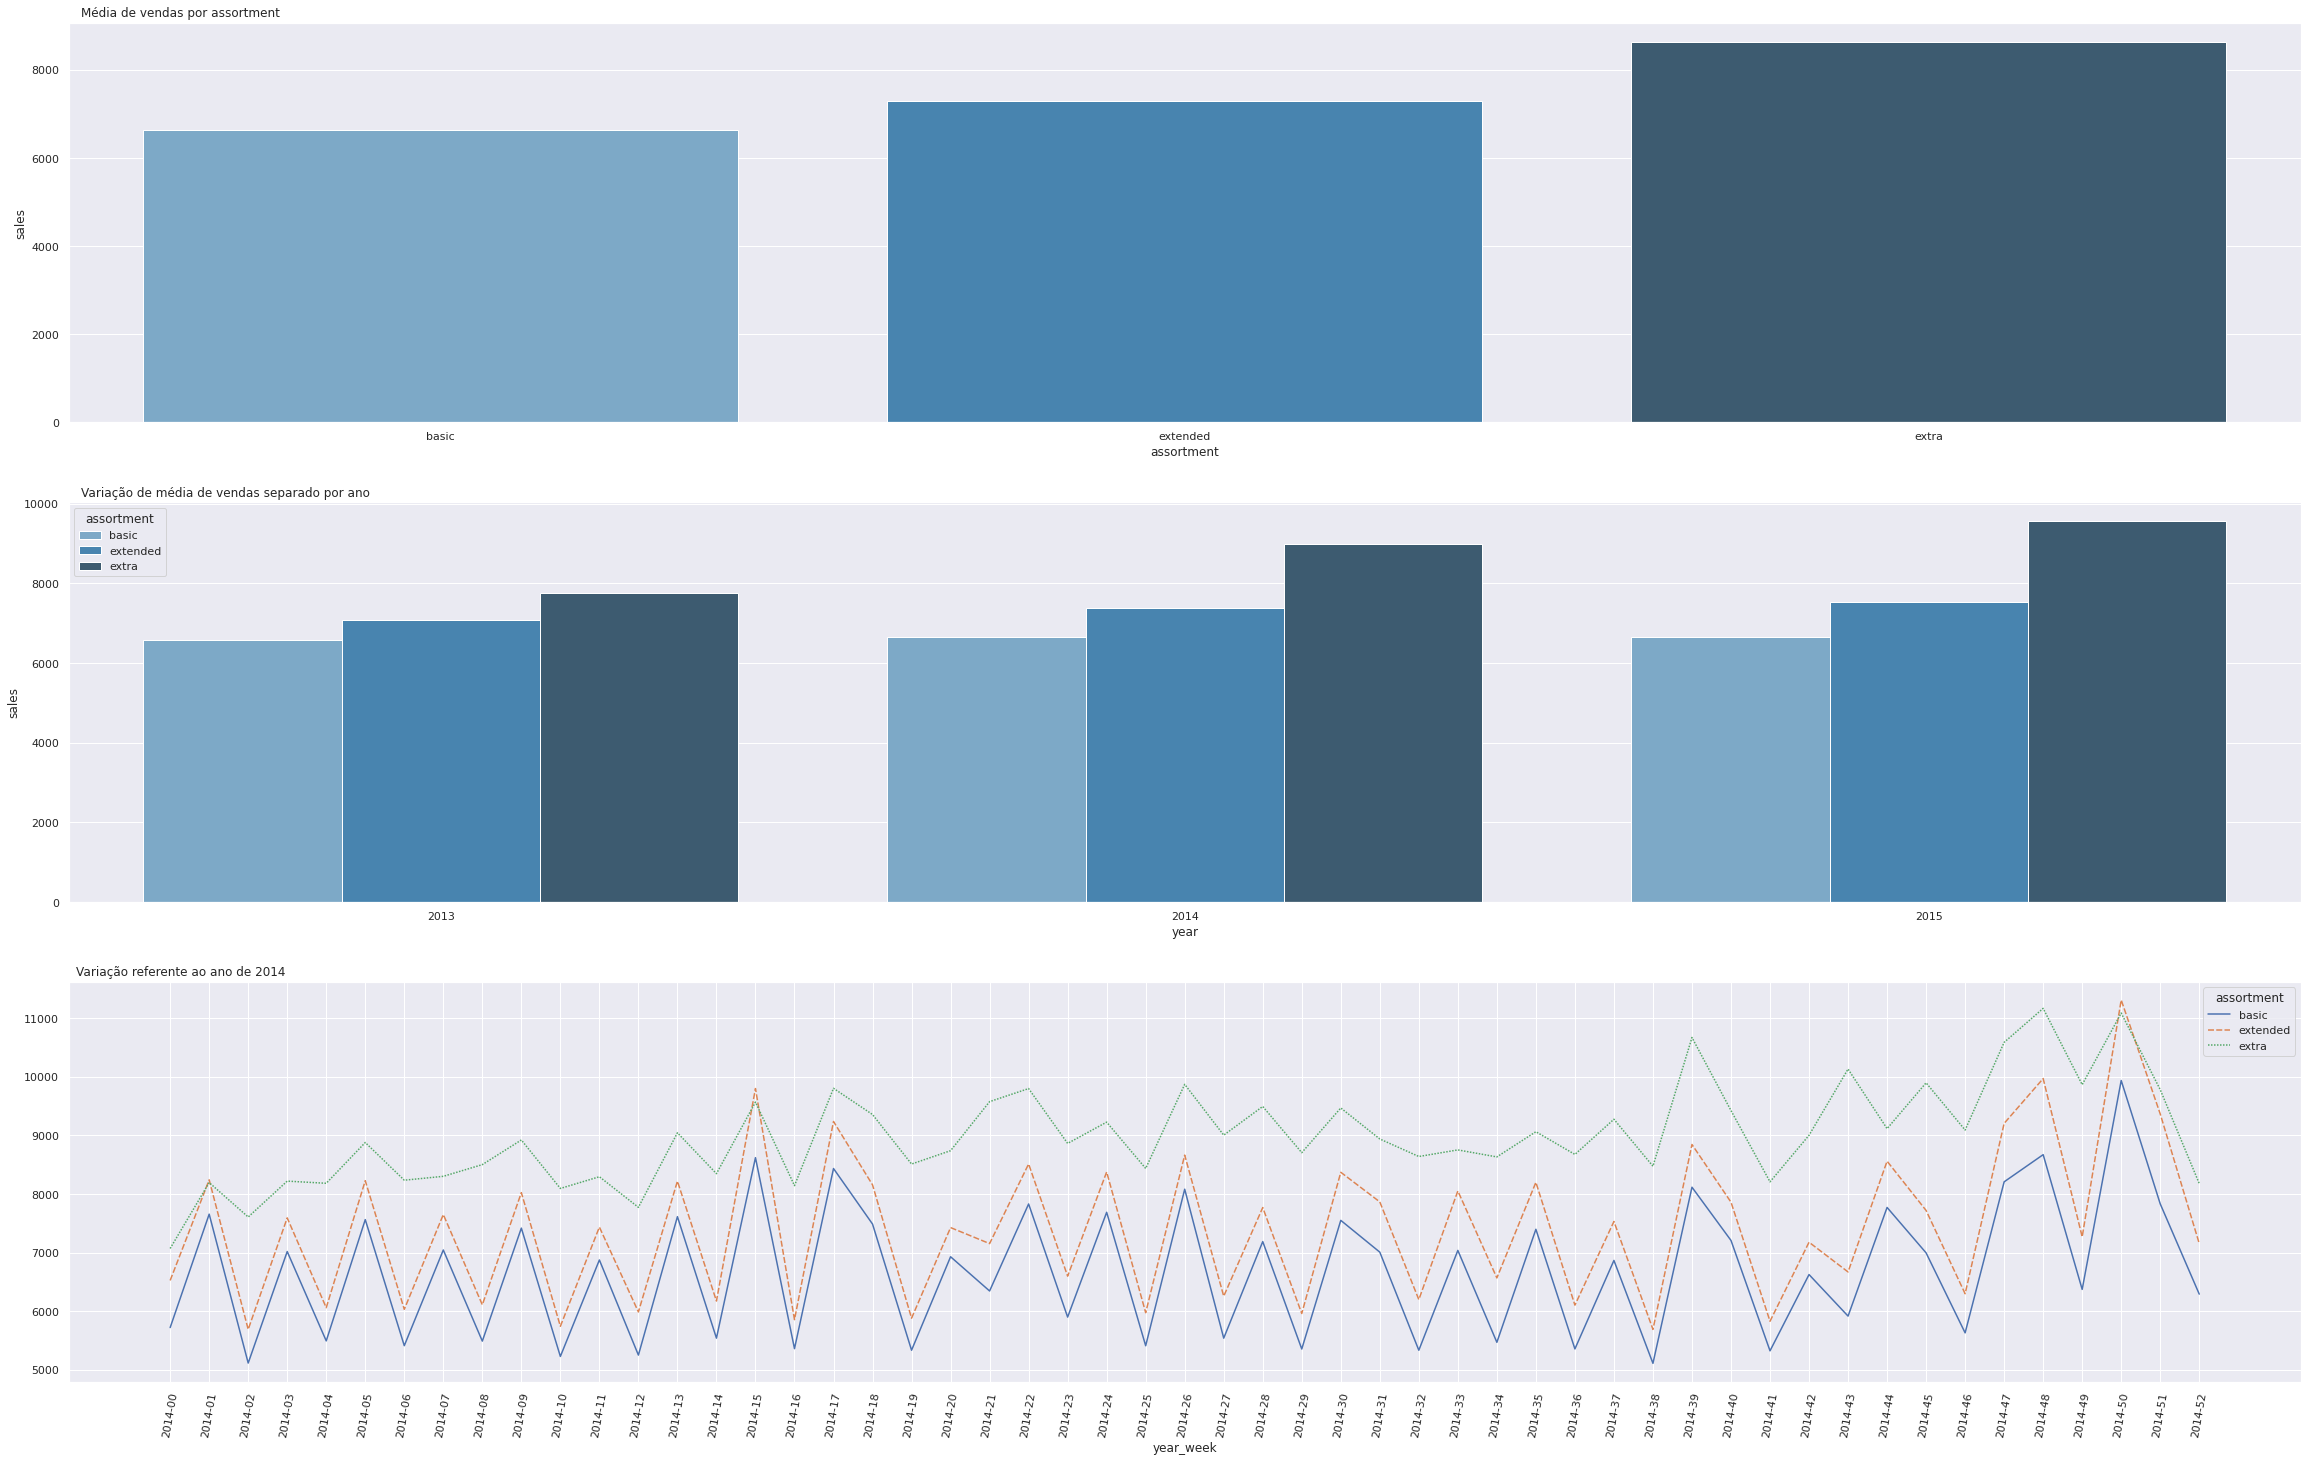

In [478]:
temp = df[['assortment','sales']].groupby('assortment').mean().reset_index()
temp1 = df[['year','assortment','sales']].groupby(['year','assortment']).mean().reset_index()
temp2 = df.loc[df.year == 2014,['year_week','assortment','sales']].groupby(['year_week','assortment']).mean().reset_index()

plt.subplot(3,1,1);
sns.barplot(data=temp, x='assortment', y='sales', palette='Blues_d');
plt.title('Média de vendas por assortment',  x= 0.05);


plt.subplot(3,1,2);
sns.barplot(data=temp1, x='year', y='sales', hue='assortment', palette='Blues_d');
plt.title('Variação de média de vendas separado por ano',  x= 0.07);

plt.subplot(3,1,3);
temp2 = temp2.pivot(index='year_week', columns='assortment', values='sales')
sns.lineplot(data=temp2);
plt.title('Variação referente ao ano de 2014',  x= 0.05);
plt.xticks(rotation= 80);





### 2. Lojas com competidores mais próximos deveriam vender menos.

    False.
    Lojas com competidores mais próximos, tendem a ter uma média de venda um pouco mais alta. 
    Apesar de haver variação entre ranges de distância, ha sim um pequeno decrécimo na média inversamente proporcional à distância da concorrência.

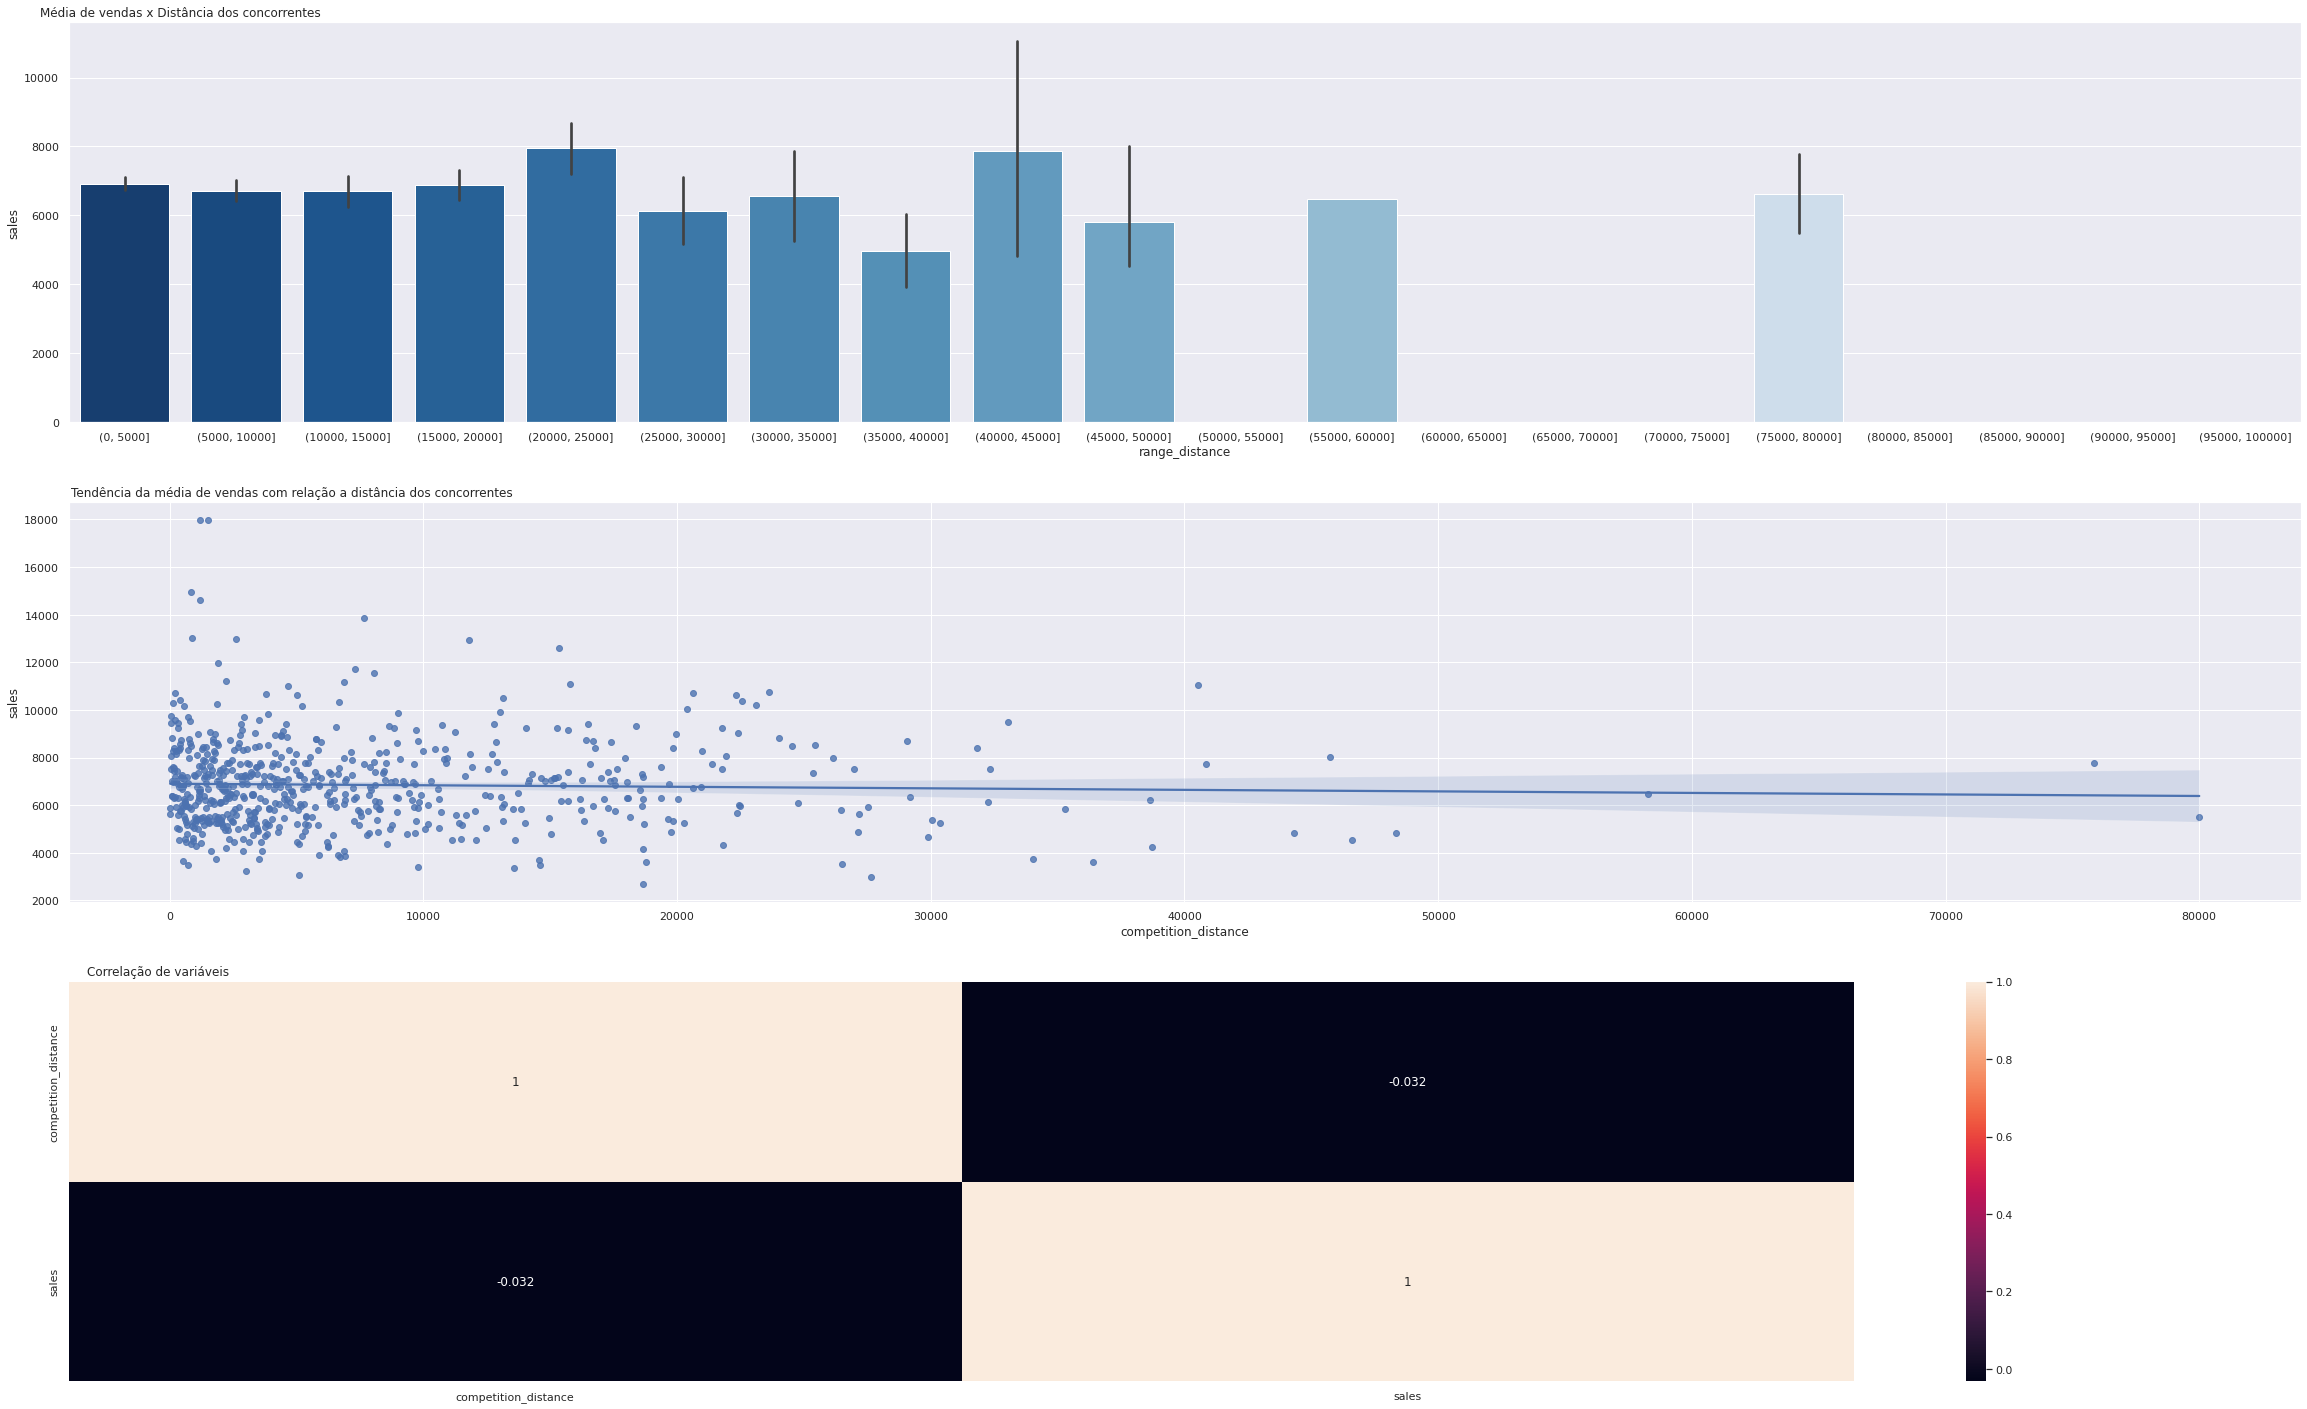

In [486]:
temp = df[['competition_distance', 'sales']].groupby('competition_distance').mean().reset_index()
bins = np.arange(0,100001,5000)
temp['range_distance'] = pd.cut(temp.competition_distance, bins=bins)

plt.subplot(3,1,1)
sns.barplot(data=temp, x='range_distance', y='sales', palette='Blues_r');
plt.title('Média de vendas x Distância dos concorrentes',  x= 0.05);


plt.subplot(3,1,2)
sns.regplot(data=temp, x='competition_distance', y='sales');
plt.title('Tendência da média de vendas com relação a distância dos concorrentes',  x= 0.1);


plt.subplot(3,1,3)
sns.heatmap(temp.corr(method='pearson'), annot=True);
plt.title('Correlação de variáveis',  x= 0.05);


### 3. Lojas com competidores a mais tempo deveriam vender menos.    

    True
    Lojas com competidores a mais tempo, tem uma tendência de alta na média de vendas

In [488]:
temp = df[['competition_time_month', 'sales']].groupby('competition_time_month').mean().reset_index()

In [489]:
temp1= temp[temp.competition_time_month < 400].copy().reset_index(drop=True)

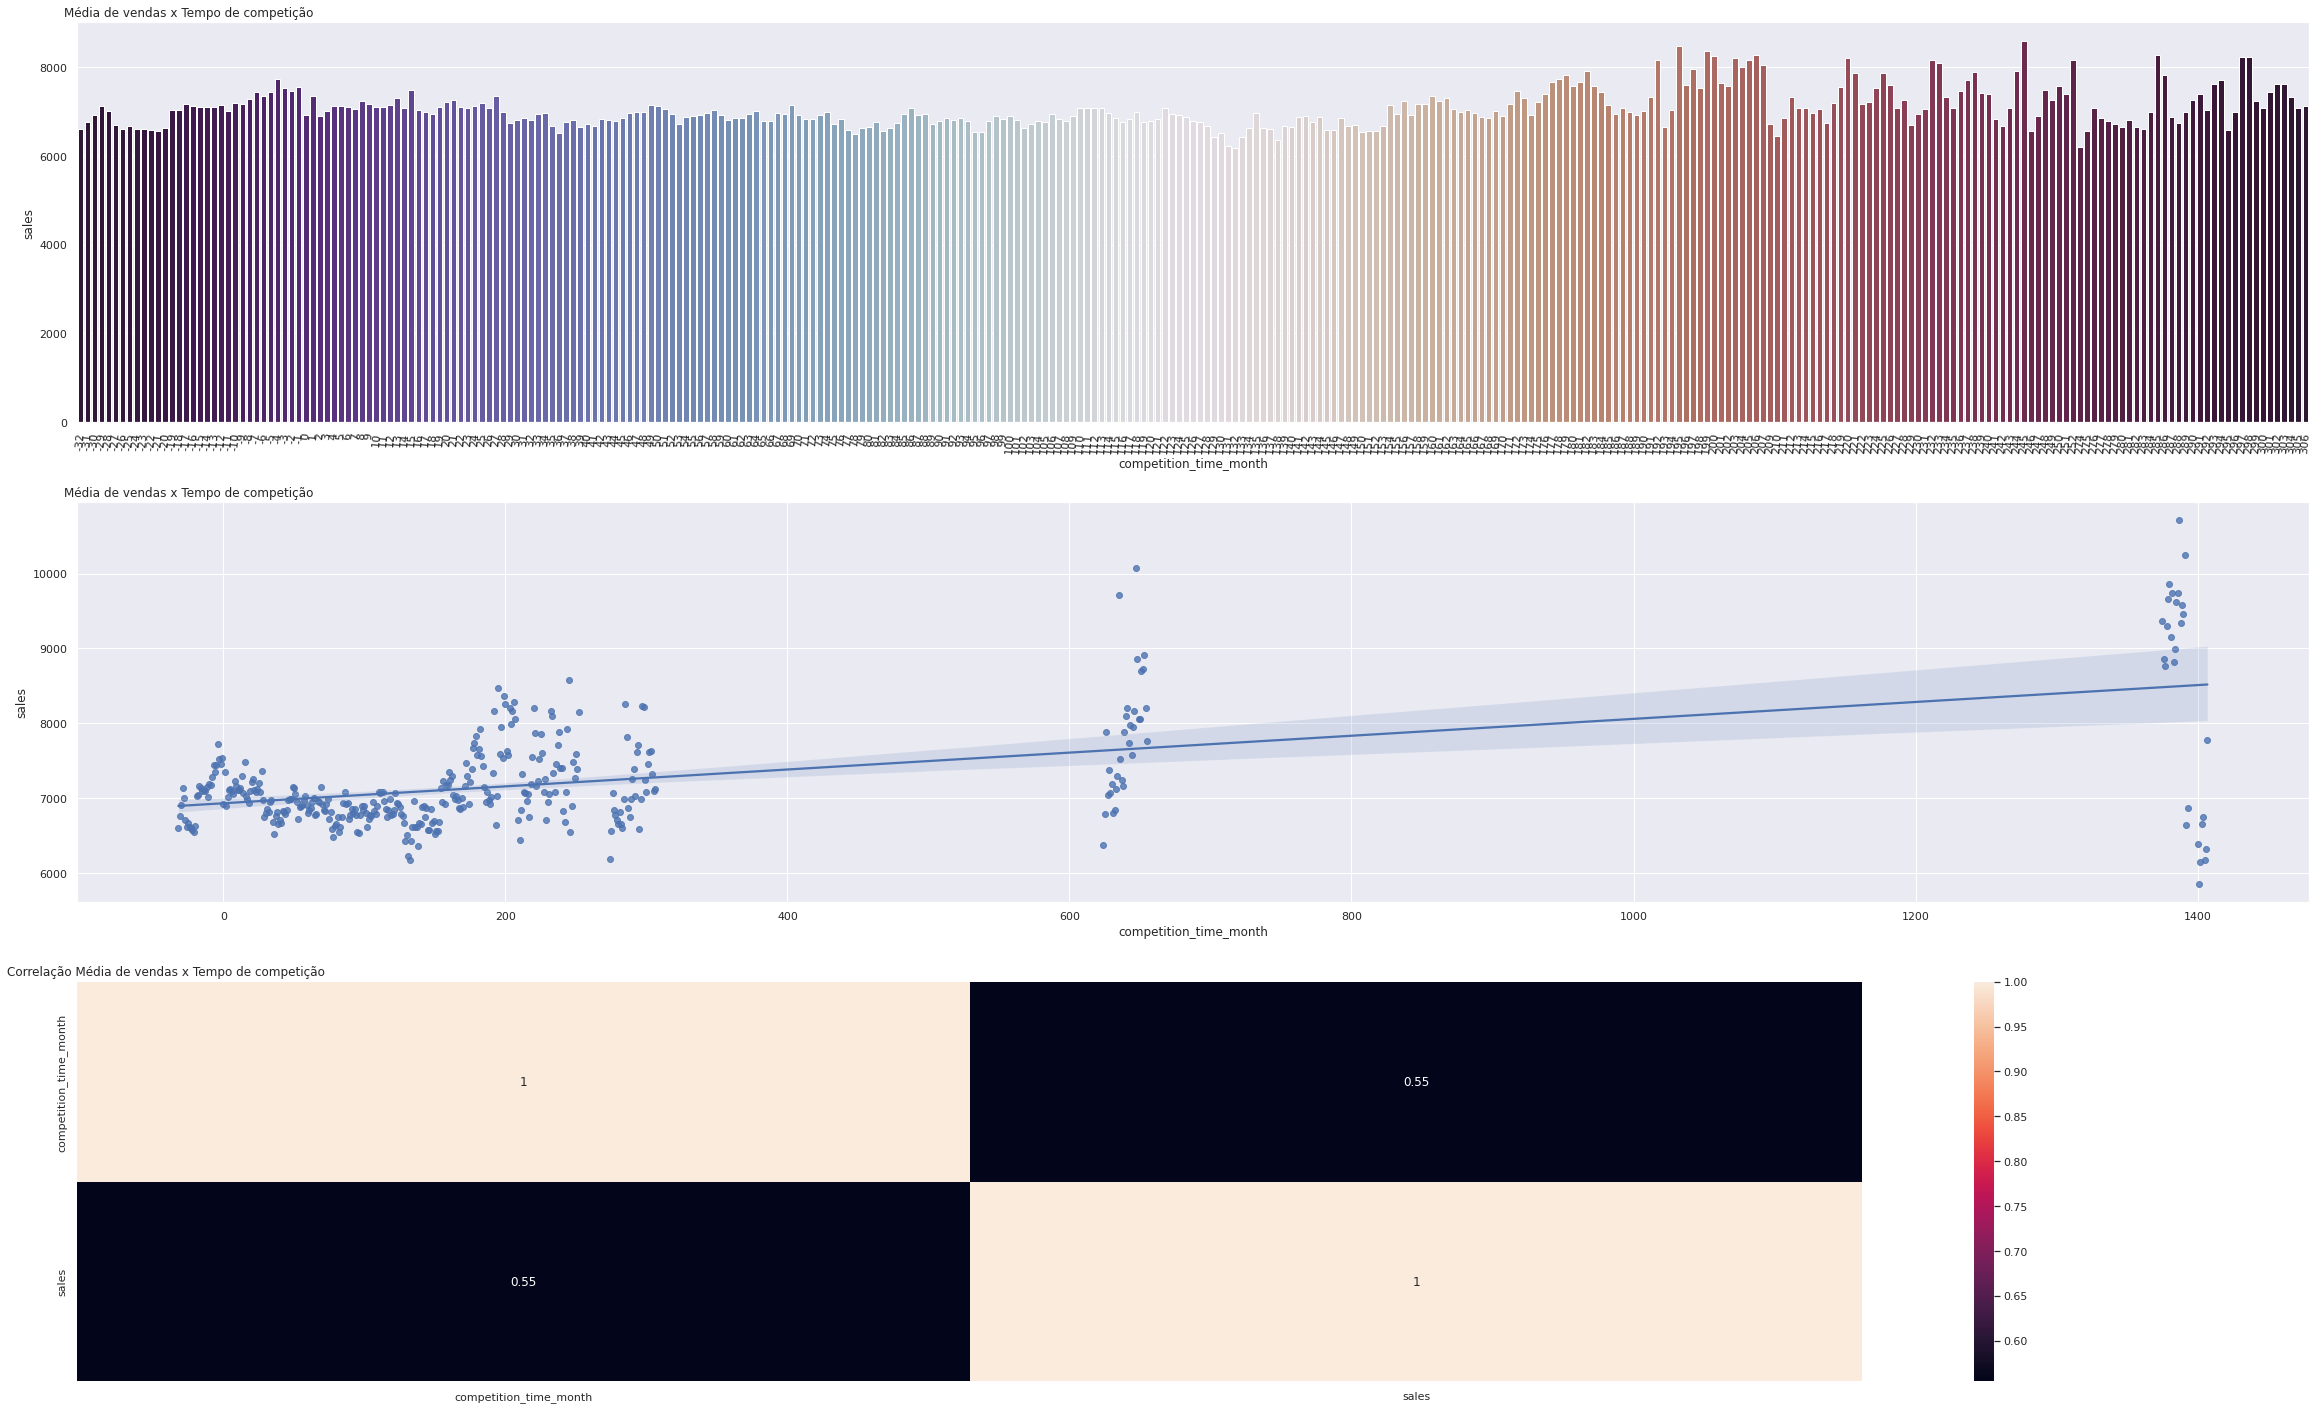

In [491]:
sns.set(rc={'figure.figsize': (40,25)})
plt.subplot(3,1,1)
sns.barplot(data=temp1, x='competition_time_month', y='sales', palette='twilight_shifted'); 
plt.xticks(rotation=85)
plt.title('Média de vendas x Tempo de competição',  x= 0.05);


plt.subplot(3,1,2)
sns.regplot(data=temp, x='competition_time_month', y='sales');
plt.title('Média de vendas x Tempo de competição',  x= 0.05);


plt.subplot(3,1,3)
sns.heatmap(temp.corr(method='pearson'), annot=True);
plt.title('Correlação Média de vendas x Tempo de competição',  x= 0.05);


###  4. Lojas com promoções ativas por mais tempo deveriam vender mais.

    True
    Lojas com promoçoes ativas por mais tempo, tem uma tendência de alta na média de vendas

In [125]:
temp = df[['promo_time_week', 'sales']].groupby('promo_time_week').mean().reset_index()

In [127]:
temp1 = temp.loc[temp.promo_time_week < 0]
temp2 = temp.loc[temp.promo_time_week >= 0]

<AxesSubplot:>

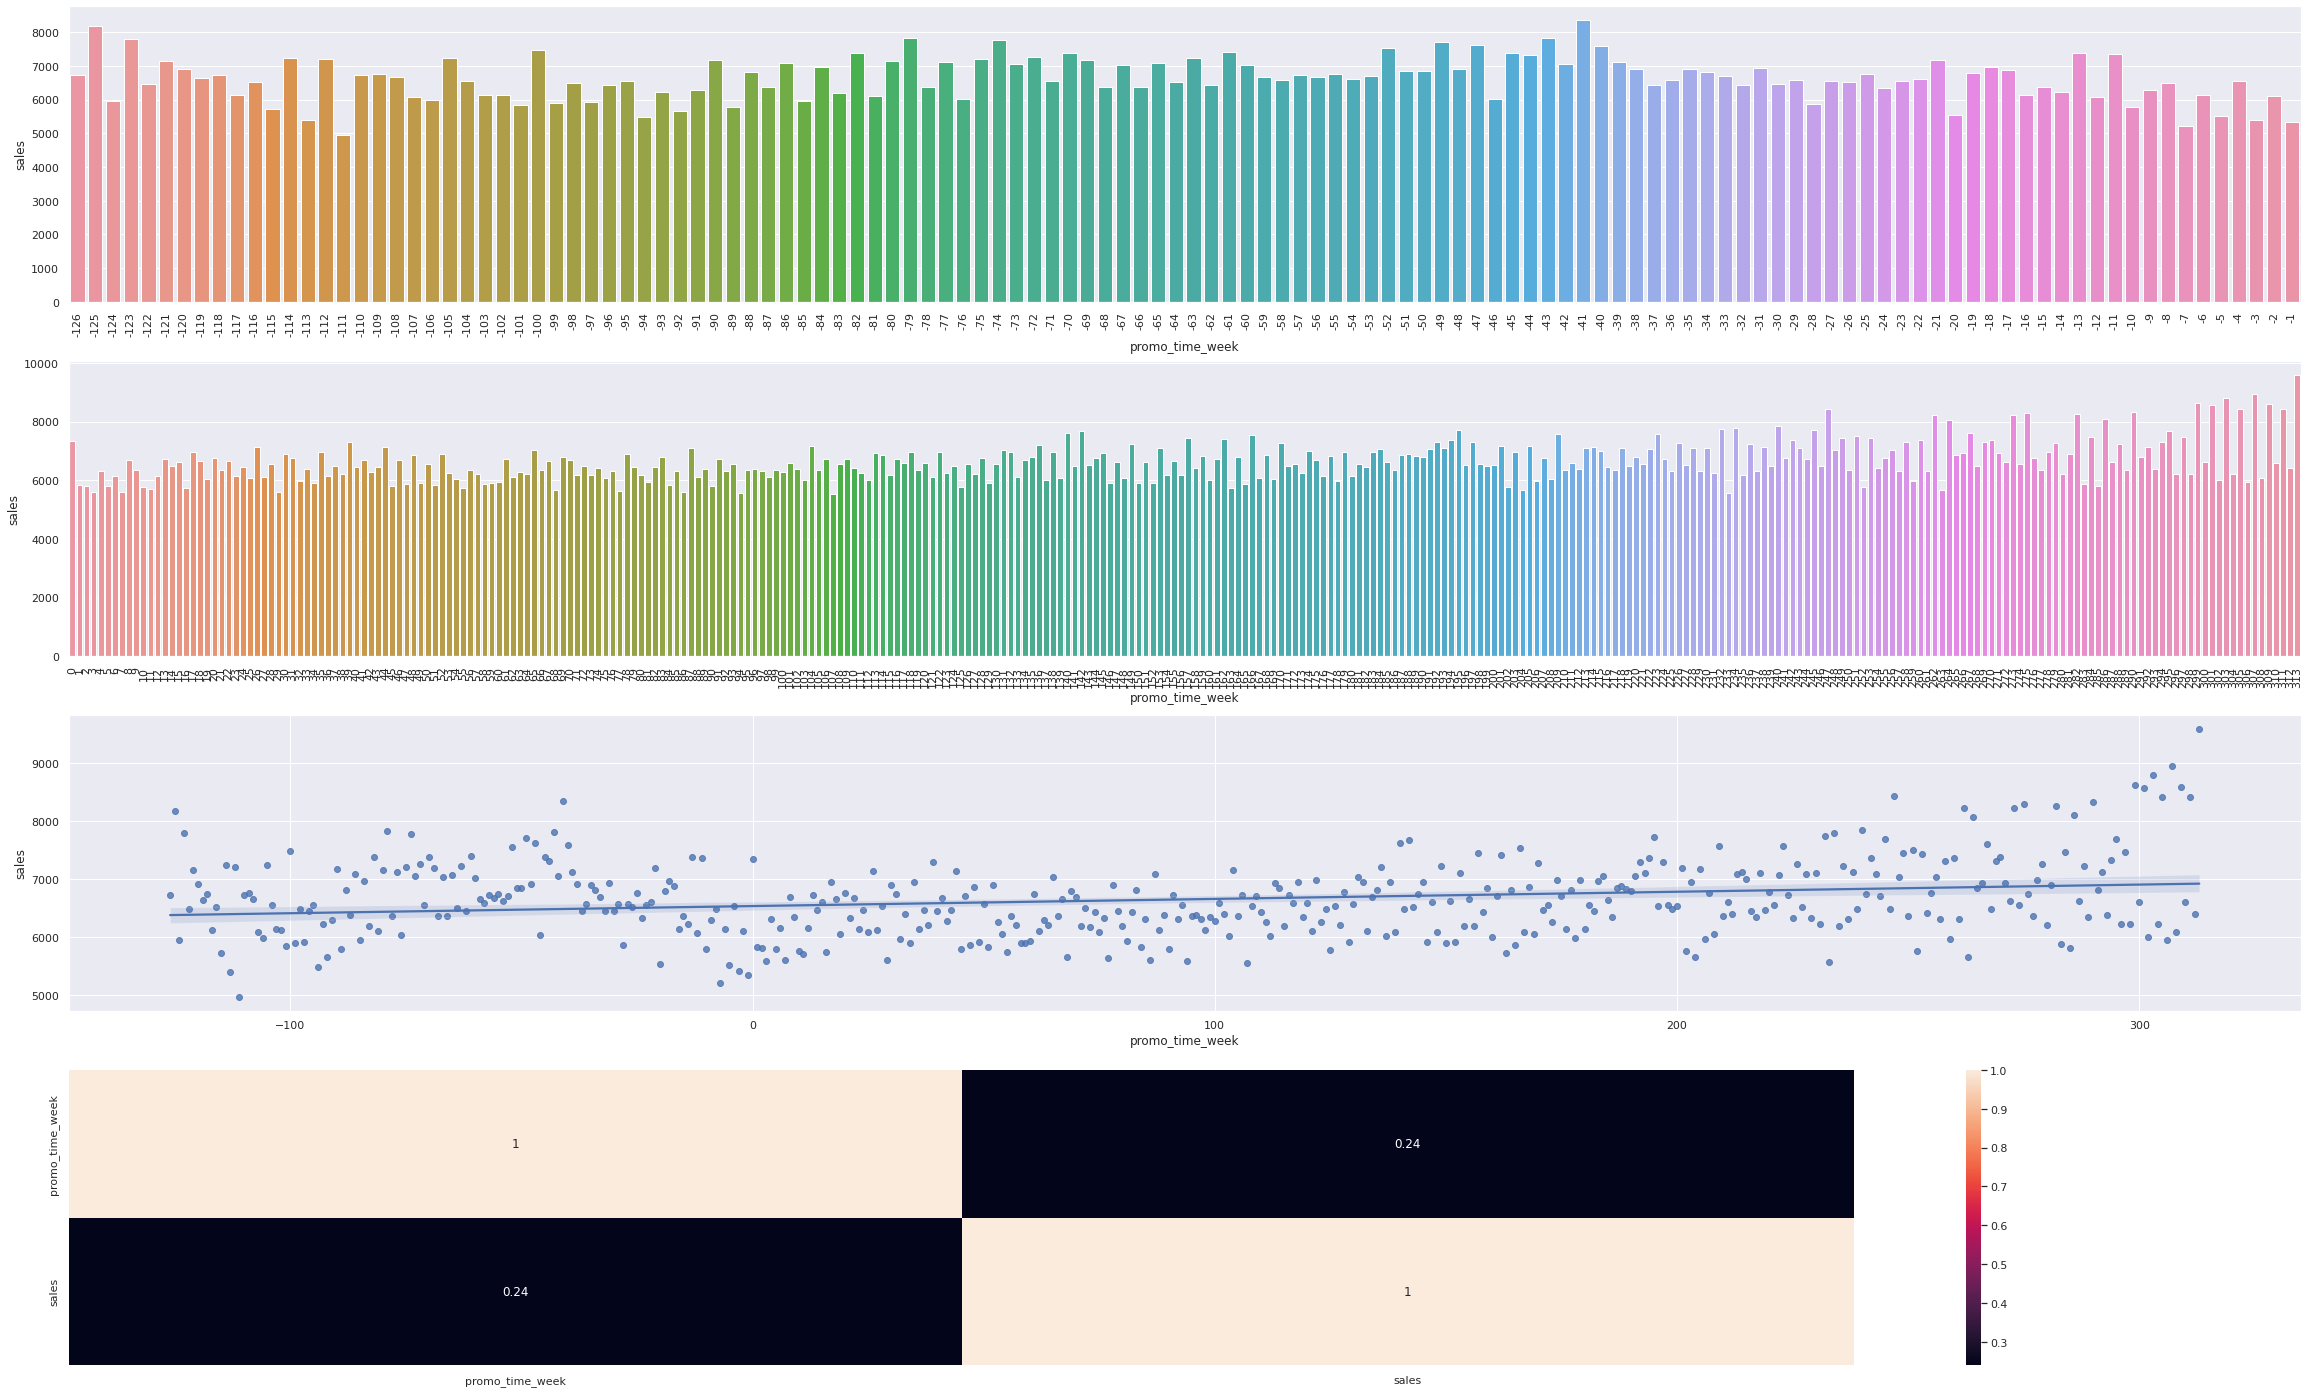

In [131]:
plt.subplot(4,1,1)
sns.barplot(data=temp1, x='promo_time_week', y='sales');
plt.xticks(rotation=90);

plt.subplot(4,1,2)
sns.barplot(data=temp2, x='promo_time_week', y='sales');
plt.xticks(rotation=90);

plt.subplot(4,1,3)
sns.regplot(data=temp, x='promo_time_week', y='sales');

plt.subplot(4,1,4)
sns.heatmap(temp.corr(method='pearson'), annot=True)

### <s> 5. Lojas com mais dias de promoção deveriam vender mais. </s> 

### 6. Lojas com mais promoções consecutivas deveriam vender mais.  

    False.
    Nota-se claramente que lojas que participaram apenas da promoção normal, tem média de vendas maior do que as demais

In [292]:
temp = df[['promo','promo2','sales']].groupby(['promo','promo2']).mean().sort_values('sales', ascending=False).reset_index()
temp1 = df[['promo_type', 'year_week', 'sales']].groupby(['promo_type', 'year_week']).mean().sort_values('year_week').reset_index()


In [297]:
temp1[temp1.promo_type == 'Ambas as promoções']

,promo_type,year_week,sales
5,Ambas as promoções,2013-01,7416.251854
10,Ambas as promoções,2013-03,6854.860662
15,Ambas as promoções,2013-05,7228.946610
21,Ambas as promoções,2013-07,7110.903192
29,Ambas as promoções,2013-09,7537.579761
...,...,...,...
391,Ambas as promoções,2015-22,8767.845610
398,Ambas as promoções,2015-24,7999.819965
404,Ambas as promoções,2015-26,8402.595513
411,Ambas as promoções,2015-28,7678.285463


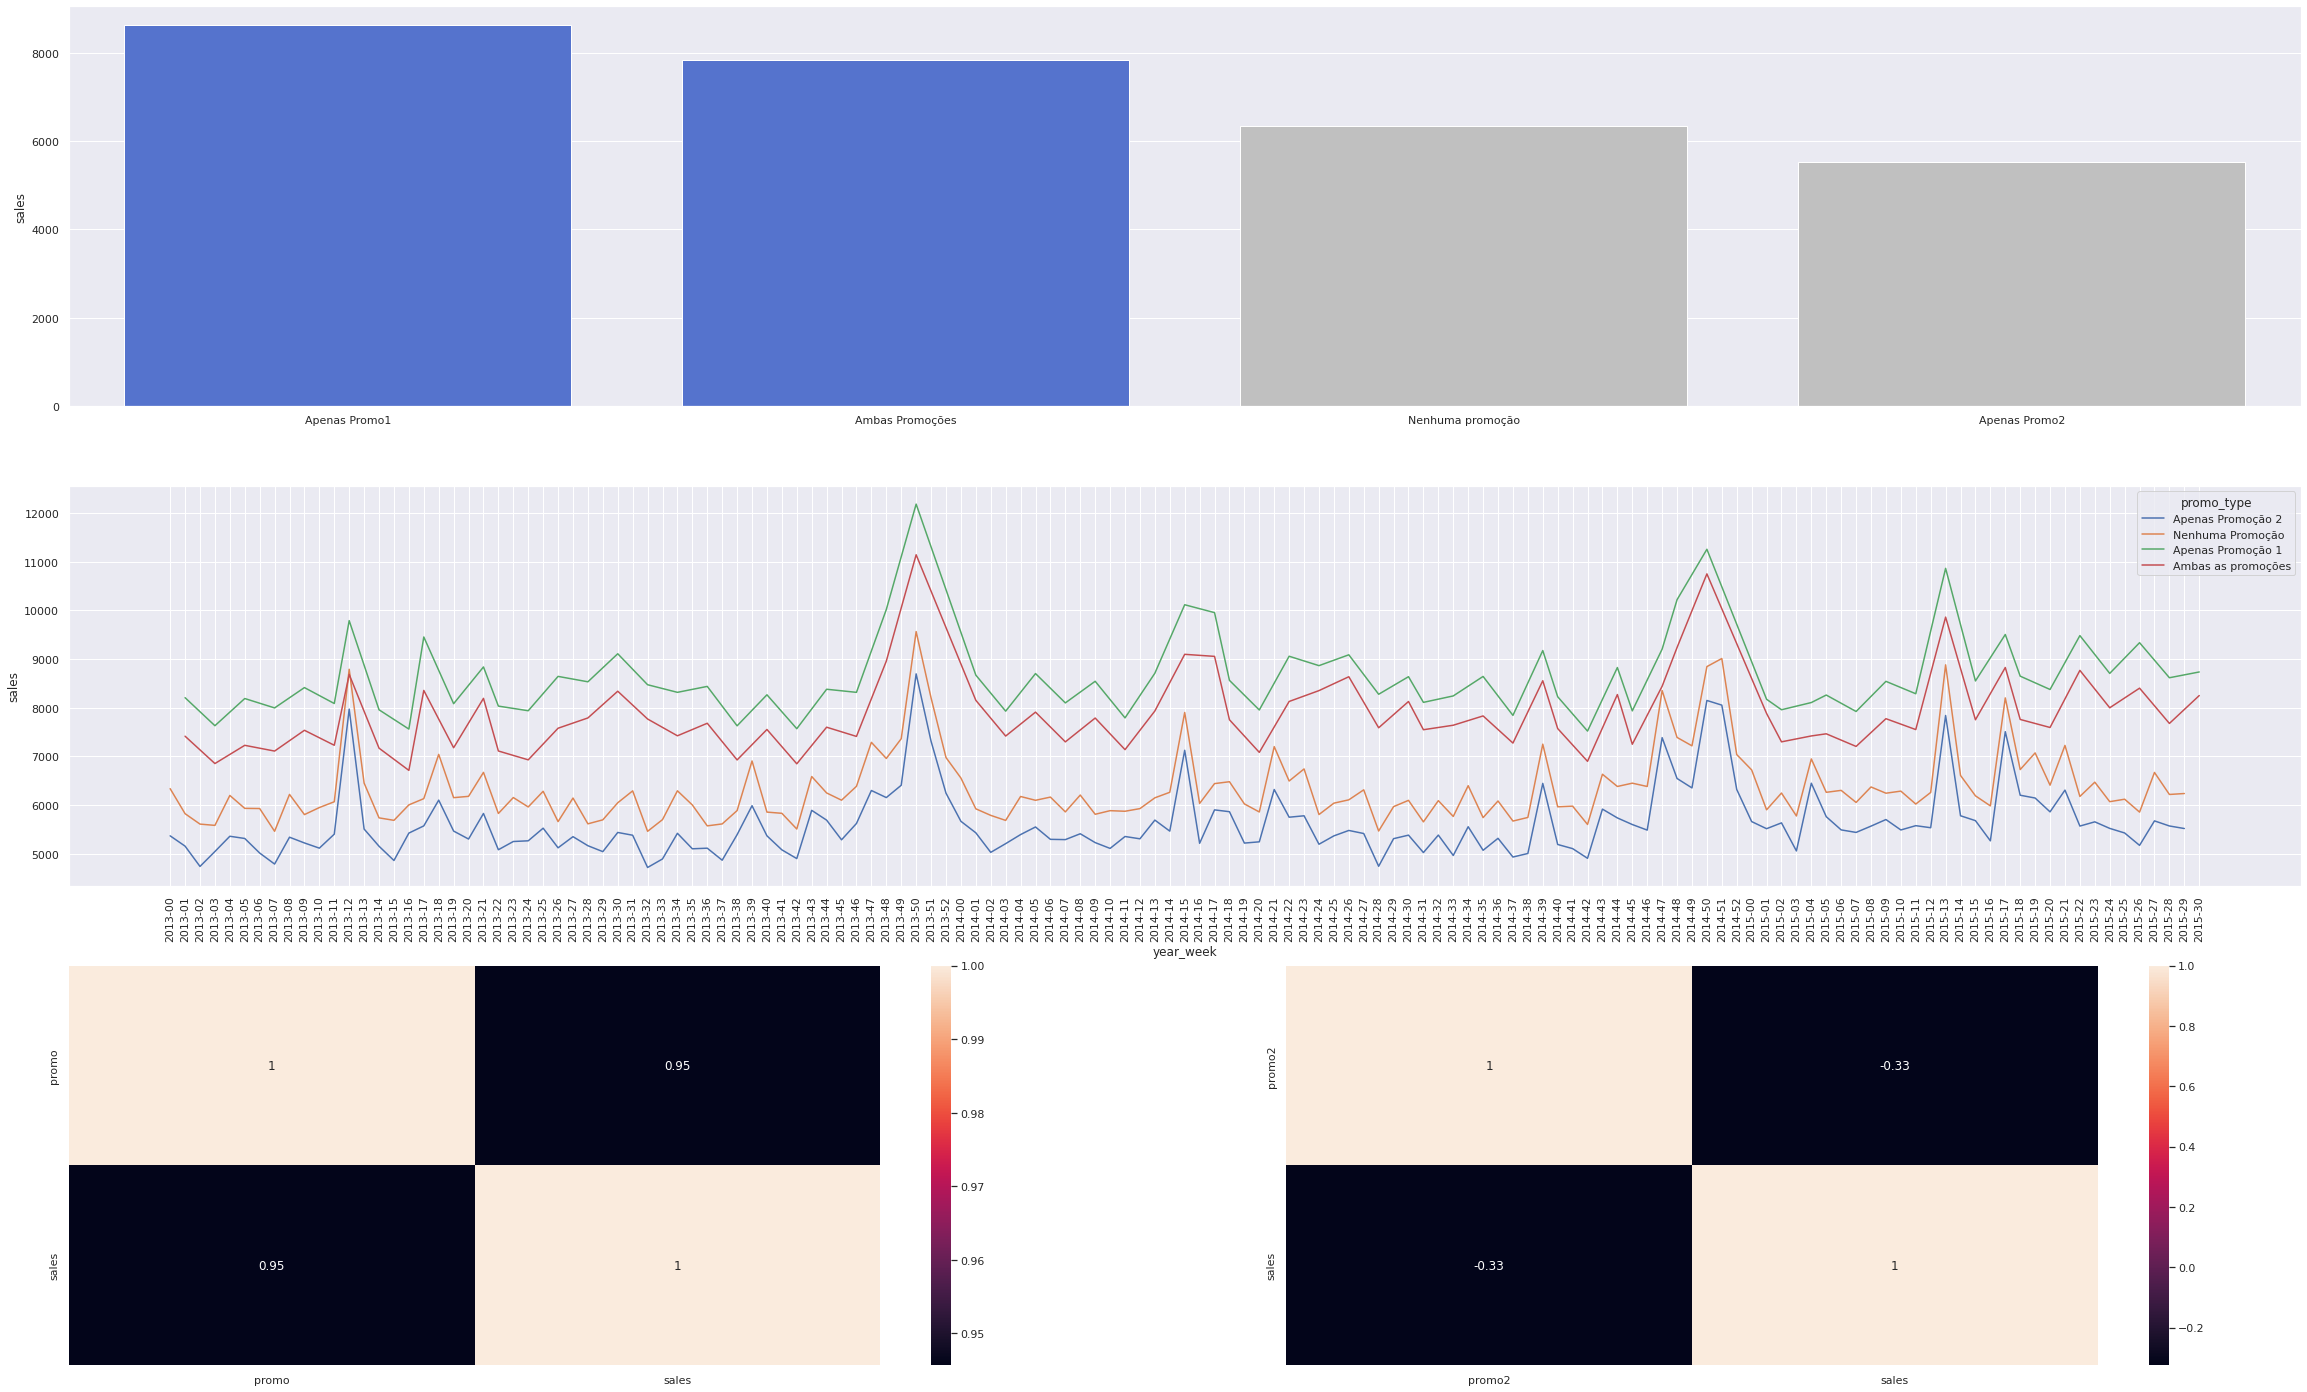

In [303]:
specs = GridSpec(nrows=3,ncols=2)

plt.subplot(specs[0,:])
sns.barplot(data=temp, x=['Apenas Promo1', 'Ambas Promoções', 'Nenhuma promoção', 'Apenas Promo2'],y='sales', palette=['royalblue','royalblue', 'silver', 'silver']);

plt.subplot(specs[1,:])
sns.lineplot(data=temp1, x='year_week', y='sales', hue='promo_type');
plt.xticks(rotation=90);

plt.subplot(specs[2,0])
sns.heatmap(temp[['promo','sales']].corr(method='pearson'), annot=True);

plt.subplot(specs[2,1])
sns.heatmap(temp[['promo2','sales']].corr(method='pearson'), annot=True);



### 7. Lojas que abrem durante o feriado de natal deveriam vender mais que nos demais feriados. 

    False
    O feriado que tem a maior quantidade de vendas é o 'easter_holiday'. Apesar de em 2014, 'chistmans' foi o que obteve maior média de vendas.

In [328]:
temp = df[['state_holiday', 'sales','year']].groupby('state_holiday').mean().sort_values('sales', ascending=False).reset_index()
temp1 = df.loc[df.year < 2015 ,['state_holiday', 'sales','year']].groupby(['state_holiday', 'year']).mean().sort_values('sales', ascending=False).reset_index()

<AxesSubplot:>

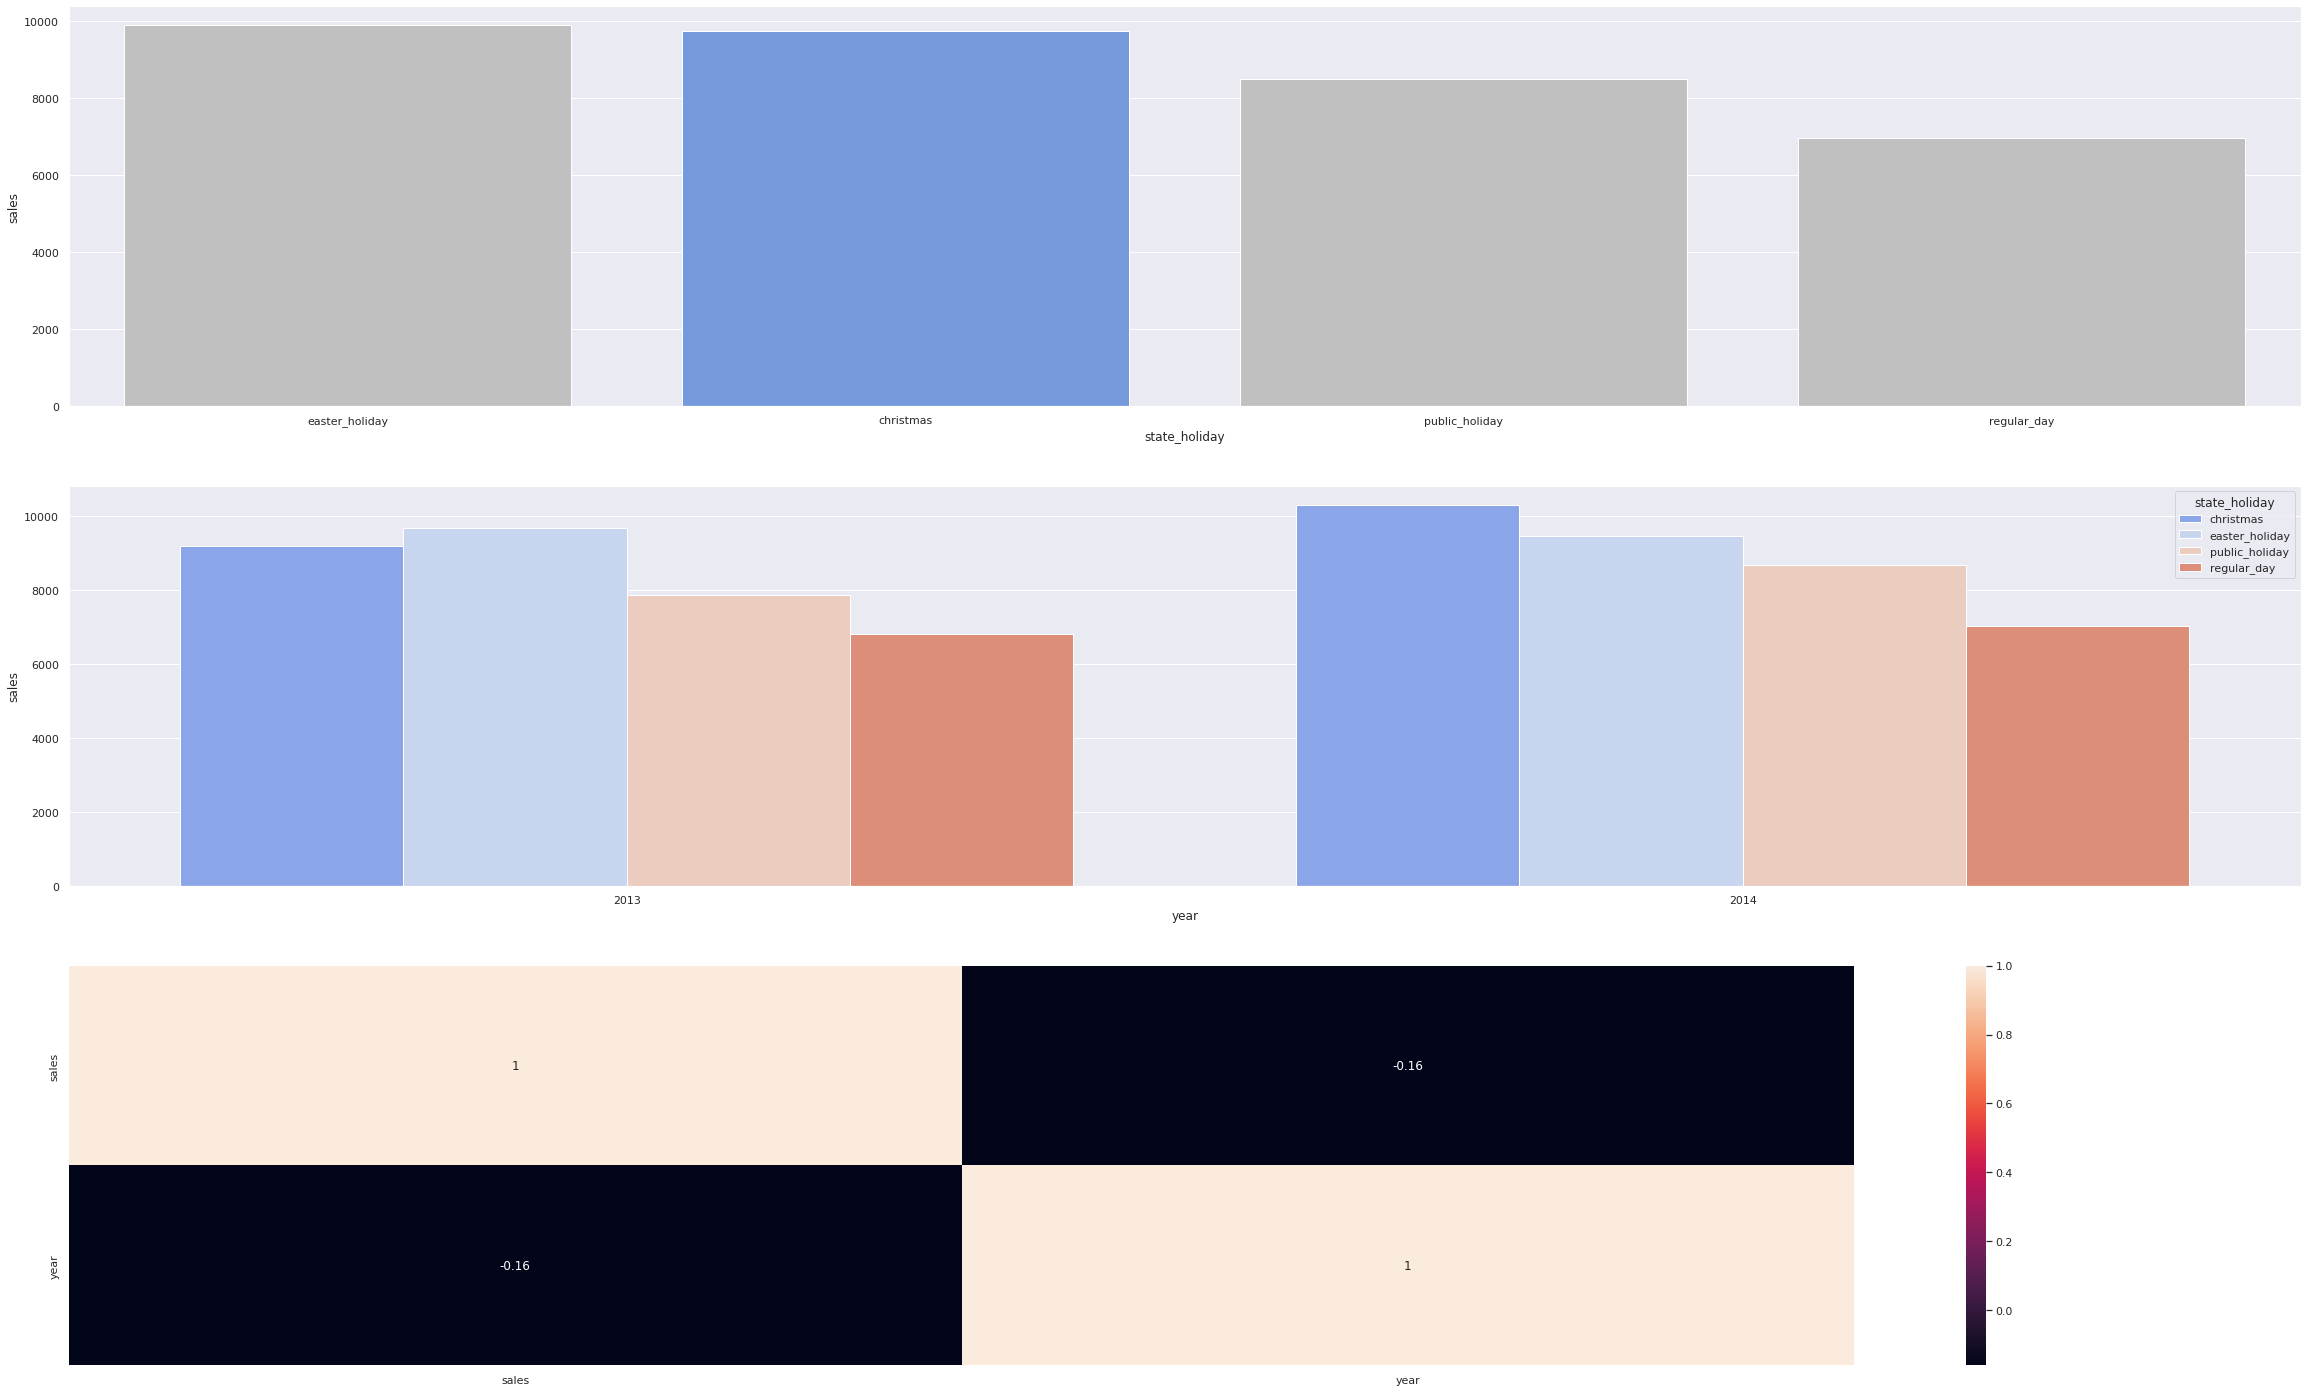

In [356]:
grid = GridSpec(3,2)

plt.subplot(grid[0,:])
sns.barplot(data=temp, x='state_holiday', y='sales', palette=['silver', 'cornflowerblue', 'silver', 'silver'])

plt.subplot(grid[1,:])
sns.barplot(data=temp1, x='year', y='sales', hue='state_holiday', palette='coolwarm')

plt.subplot(grid[2,:])
sns.heatmap(temp.corr(method='pearson'), annot=True)


### 8. Lojas deveriam vender mais ao longo dos anos.

    False
    Nota-se um decrécimo no total de vendas em 2014 com relação a 2013

In [368]:
sns.set(rc={'figure.figsize':(40,25)})

In [382]:
temp = df.loc[df.year < 2015,['year','sales']].groupby('year').sum().reset_index()

<AxesSubplot:>

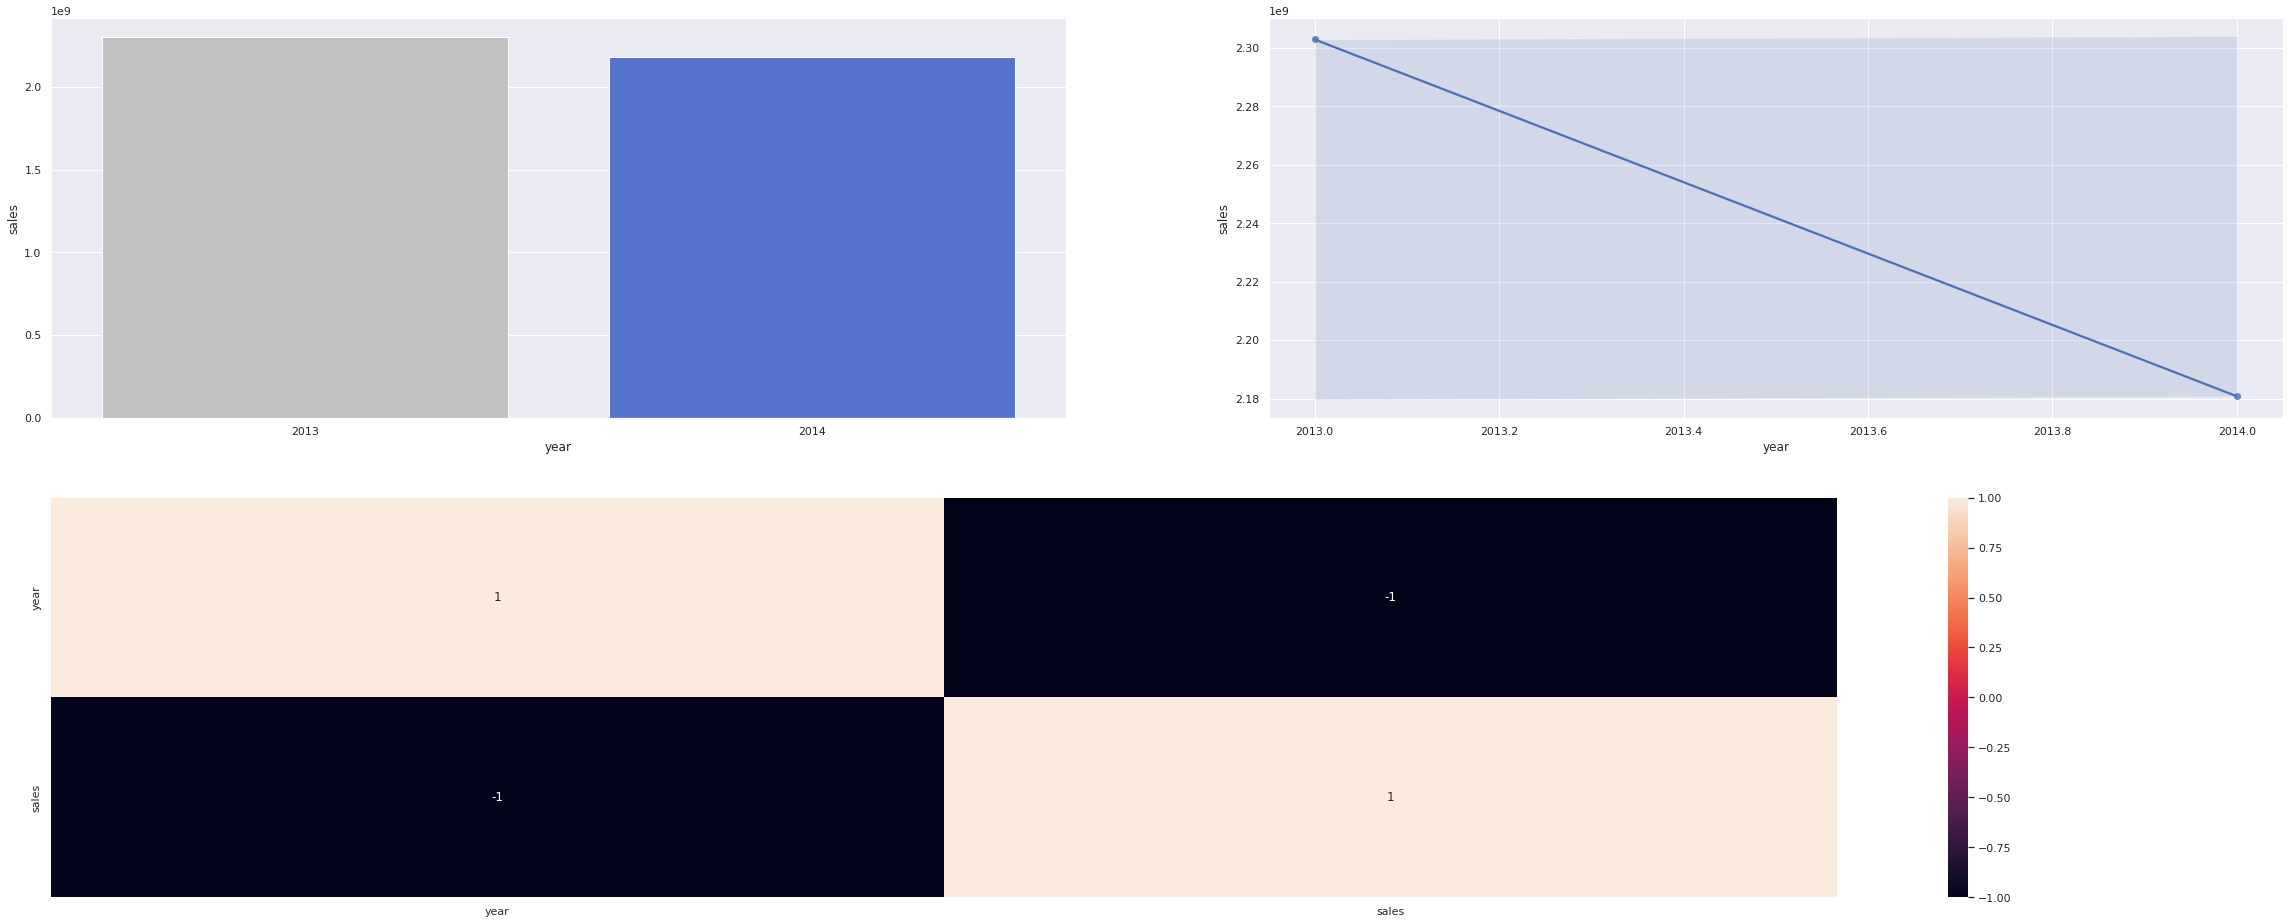

In [383]:
plt.subplot(grid[0,0])
sns.barplot(data=temp, x='year', y='sales', palette=['silver', 'royalblue'])

plt.subplot(grid[0,1])
sns.regplot(data=temp, x='year', y='sales')

plt.subplot(grid[1,:])
sns.heatmap(temp.corr(method='pearson'), annot=True)

### 9. Lojas deveriam vender mais no segundo semestre do ano.

    True
    No segundo semestre, o total de vendas foi superior em $932,380.00

In [423]:
temp = df.loc[df.year < 2015 ,['sales','month']].groupby('month').sum().reset_index()
temp1 = df.loc[df.year < 2015 ,['semester','sales']].groupby('semester').sum().reset_index()

<AxesSubplot:>

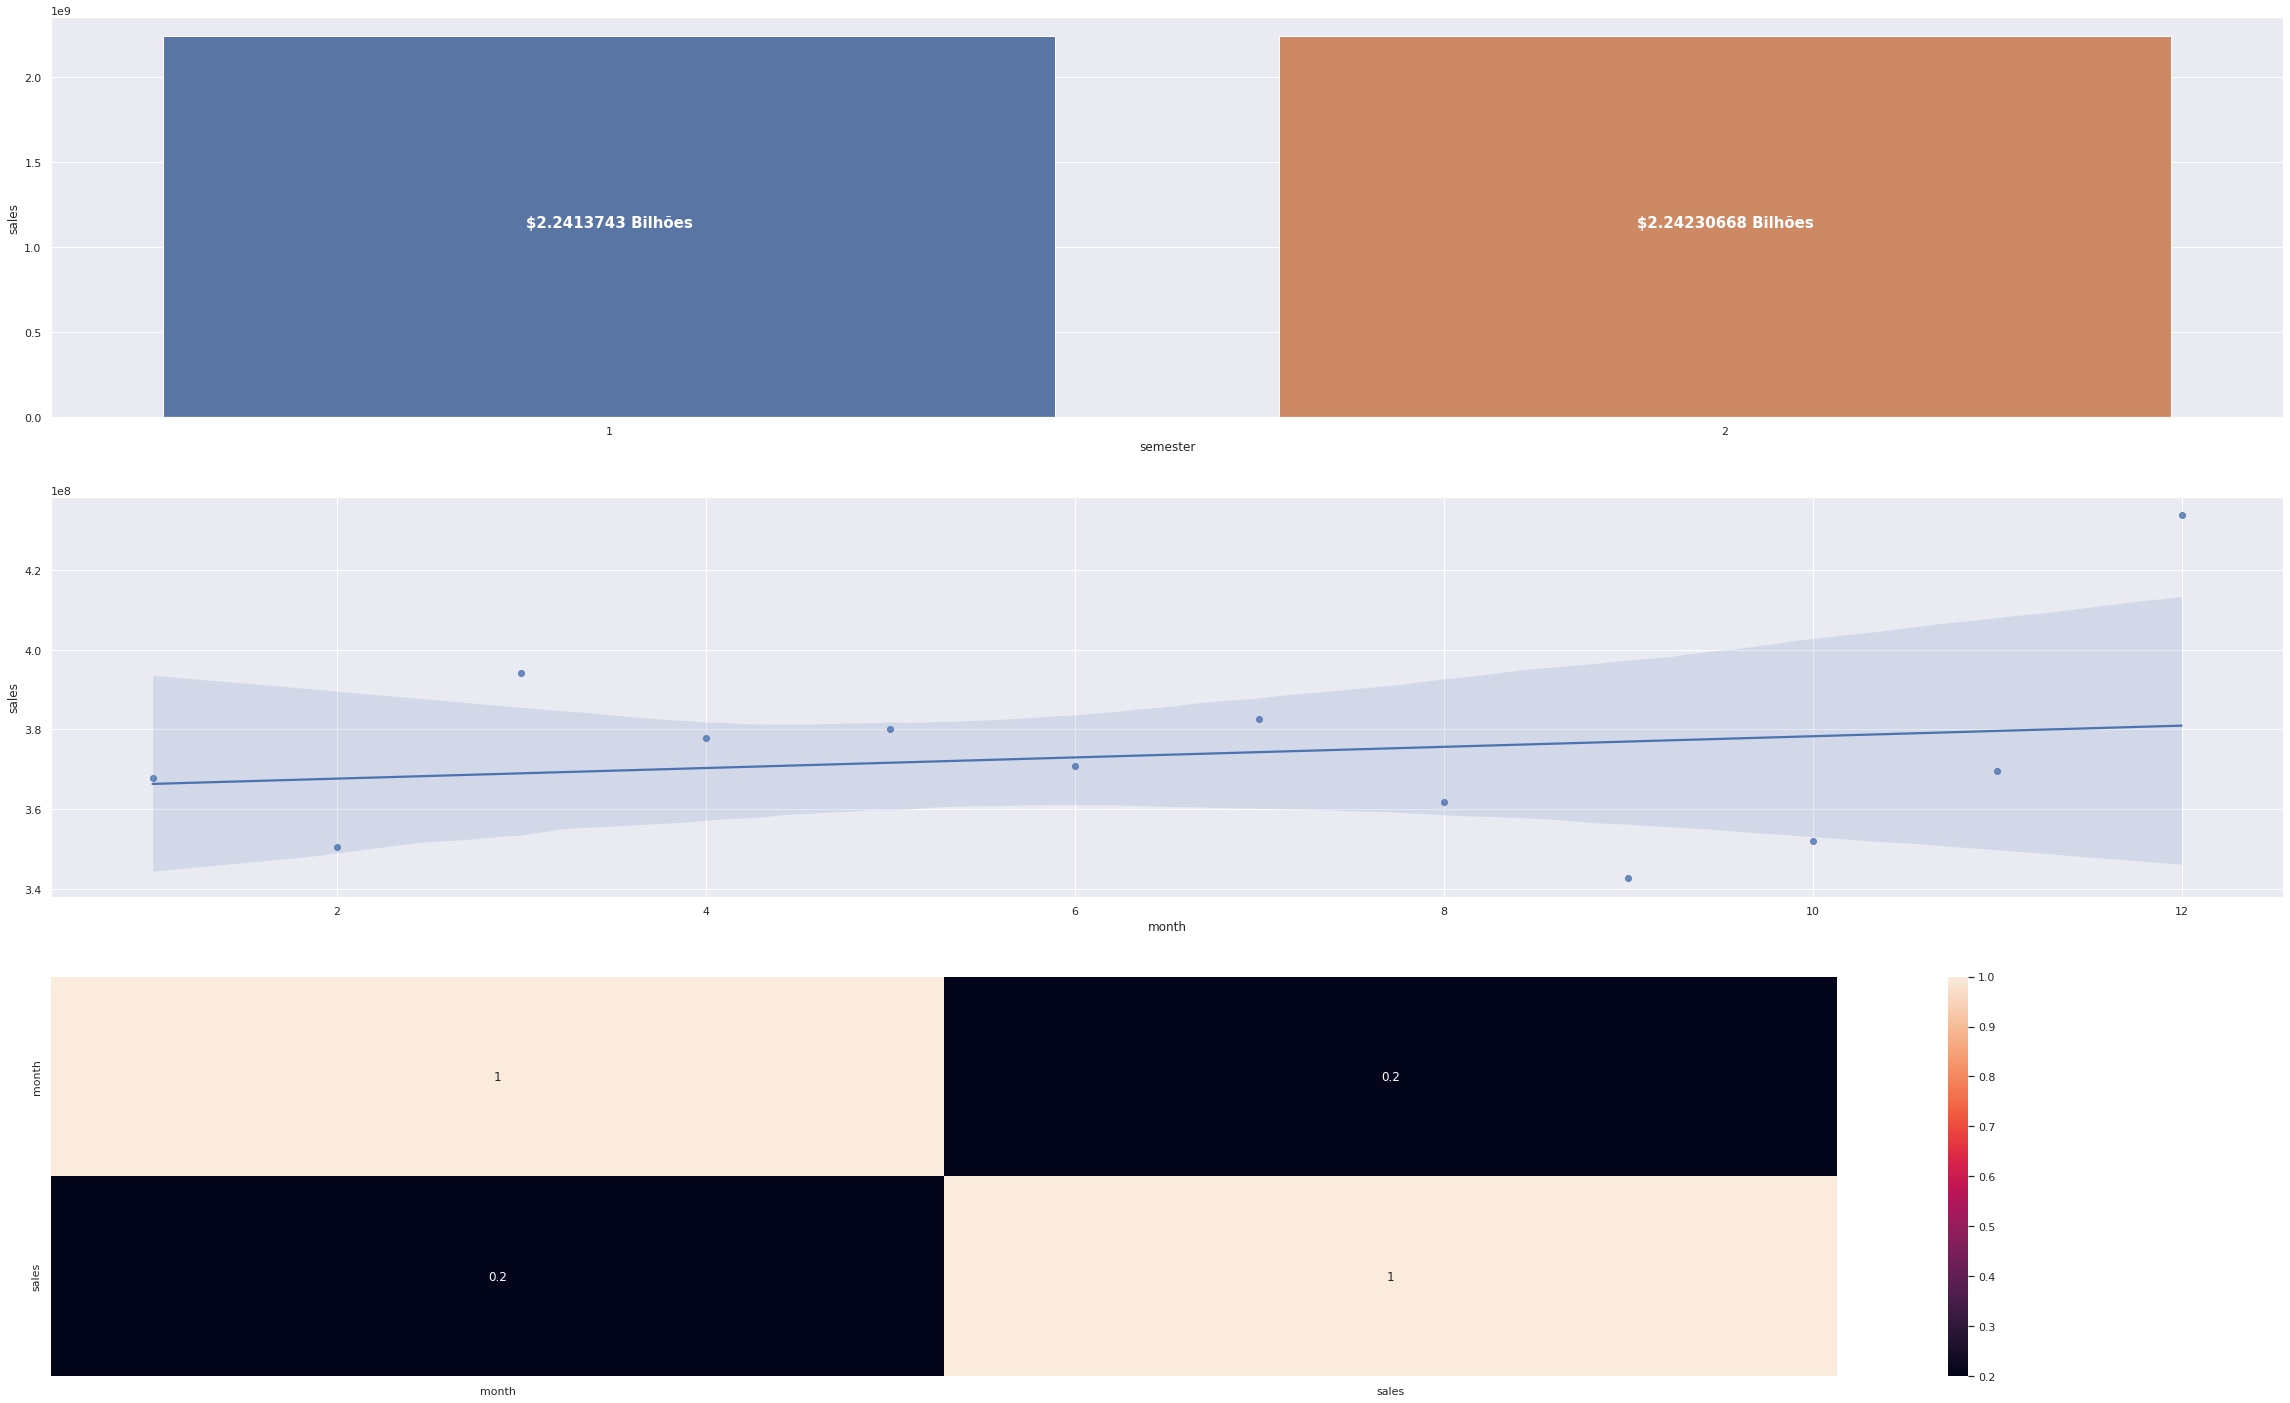

In [425]:
plt.subplot(grid[0,:])
ax = sns.barplot(data=temp1, x='semester', y='sales')
for i in ax.patches:
    ax.annotate(
        #Texto a ser plotado
        '$' + str(i.get_height() / 1000000000) + ' Bilhões',
        #Posição horizontal
        (i.get_x() + i.get_width() /2, i.get_height() /2 ),
        ha='center' ,   
        color='white' ,
        weight='bold',
        fontsize=15
    );

plt.subplot(grid[1,:])
sns.regplot(data=temp, x='month', y='sales')

plt.subplot(grid[2,:])
sns.heatmap(temp.corr(method='pearson'), annot=True)


### 10. Lojas deveriam vender mais após o dia 10 de cada mês.

    True
    A média de vendas antes do dia 10 é realmente maior

In [463]:
temp = df[['day', 'sales']].groupby('day').mean().reset_index()
temp1 = df.loc[df.day > 10,['day', 'sales']].groupby('day').mean().reset_index()
before = df.loc[df.day <= 10,'sales'].mean()
after =  df.loc[df.day > 10,'sales'].mean()

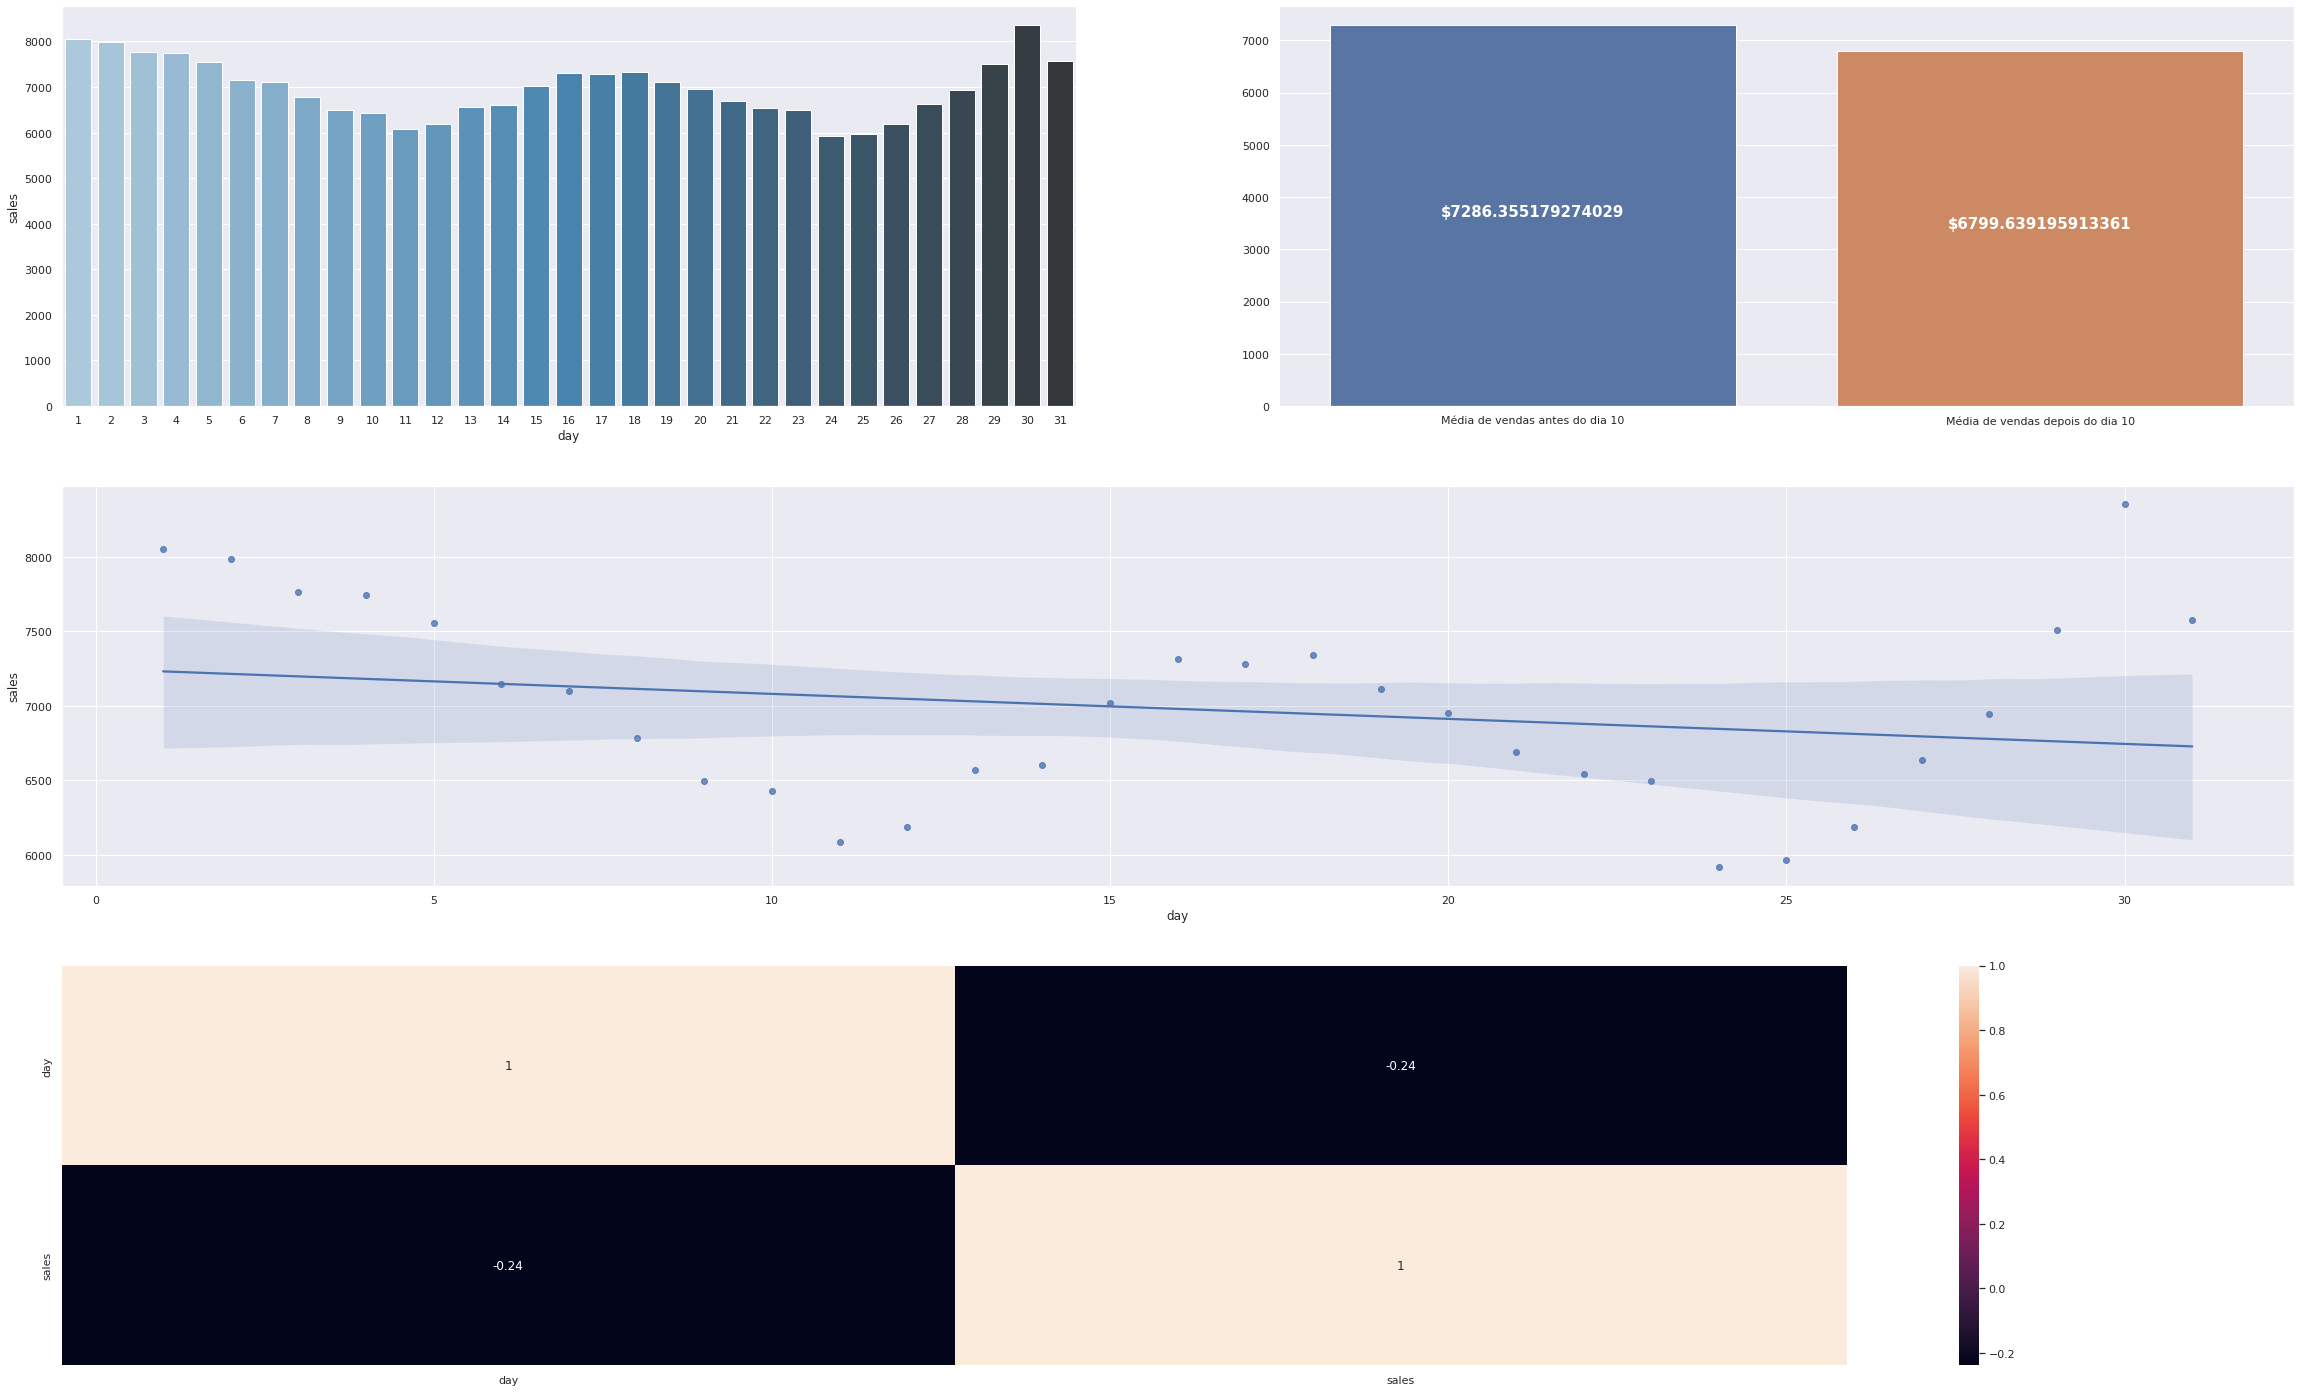

In [477]:
plt.subplot(specs[0,0])
sns.barplot(data=temp,x='day', y='sales', palette='Blues_d');

plt.subplot(specs[0,1])
ax = sns.barplot(x=['Média de vendas antes do dia 10','Média de vendas depois do dia 10'], y=[before, after]);
for i in ax.patches:
    ax.annotate(
        #Texto a ser plotado
        '$' + str(i.get_height()),
        #Posição horizontal
        (i.get_x() + i.get_width() /2, i.get_height() /2 ),
        ha='center' ,   
        color='white' ,
        weight='bold',
        fontsize=15
    );

plt.subplot(specs[1,:])
sns.regplot(data=temp,x='day', y='sales');


plt.subplot(specs[2,:])
sns.heatmap(temp.corr(method='pearson'), annot=True);
